In [1]:
# Install Kaggle API
!pip install -q kaggle

In [2]:
# Import libraries
import os
from google.colab import files
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm

In [3]:
# Check if the API key already exists
if not os.path.exists('/root/.kaggle/kaggle.json'):
    print('Please upload your personal kaggle.json file:')

    # Prompt for upload
    uploaded = files.upload()

    # Move the file to the correct directory
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print('\nKaggle API key configured successfully.')
else:
    print('Kaggle API key is already configured.')

Please upload your personal kaggle.json file:


Saving kaggle.json to kaggle.json

Kaggle API key configured successfully.


In [5]:
# Replace with your dataset id here
kaggle_dataset_id = 'andymalinsky/rsna-2022-hdf5-subset'

print('Downloading dataset...')
!kaggle datasets download -d {kaggle_dataset_id}

Dataset URL: https://www.kaggle.com/datasets/andymalinsky/rsna-2022-hdf5-subset
License(s): CC0-1.0
 99% 3.49G/3.51G [00:53<00:00, 275MB/s]
100% 3.51G/3.51G [00:53<00:00, 70.7MB/s]


In [6]:
# Unzip and move to the local Colab storage
zip_name = kaggle_dataset_id.split('/')[-1] + '.zip'
!unzip -q '{zip_name}'

# This is the path to the data
data_path = 'fracture_dataset_subset.h5'

In [7]:
# Open and view the file
with h5py.File(data_path, 'r') as f:
    # View key list, essentially our 'columns'
    print(f'Keys: {list(f.keys())}')

    # View column shapes
    print('\n--- Details ---')
    for key in f.keys():
        dataset = f[key]
        print(f'\nKey: {key}')
        print(f'Shape: {dataset.shape}')
        print(f'Dtype: {dataset.dtype}')

Keys: ['SliceNumber', 'StudyInstanceUID', 'bboxes', 'images', 'labels', 'split']

--- Details ---

Key: SliceNumber
Shape: (28812,)
Dtype: object

Key: StudyInstanceUID
Shape: (28812,)
Dtype: object

Key: bboxes
Shape: (28812, 10, 4)
Dtype: float32

Key: images
Shape: (28812, 256, 256)
Dtype: float32

Key: labels
Shape: (28812,)
Dtype: int8

Key: split
Shape: (28812,)
Dtype: int8


In [8]:
# Define visualizer function
def visualize_samples(num_samples, label):
    with h5py.File(data_path, 'r') as hf:
        # Load all labels and find the indices for the desired sample type
        all_labels = hf['labels'][:]
        indices_to_sample_from = np.where(all_labels == label)[0]
        sample_indices = random.sample(list(indices_to_sample_from), num_samples)
        fig, axes = plt.subplots(1, num_samples, figsize=(10, 10))

        for ax, idx in zip(axes, sample_indices):
            # Load the data for this one sample
            image = hf['images'][idx]
            bboxes = hf['bboxes'][idx]
            uid = hf['StudyInstanceUID'][idx]
            slice_num = hf['SliceNumber'][idx]
            label = hf['labels'][idx]

            # Filter out the "-1" padding on the bounding boxes
            bboxes = [box for box in bboxes if box[0] != -1.0]

            # Plot the image
            ax.imshow(image, cmap='bone')
            # Set title
            ax.set_title(f'Negative Sample (Label: {label}) \nSlice: {slice_num} | (Index: {idx})')

            # Plot each bounding box
            for box in bboxes:
                x, y, w, h = box # the box value contains its coordinates and dimensions

                # Draw the bounding box on the image
                rect = patches.Rectangle(
                    (x, y), w, h,
                    linewidth=2,
                    edgecolor='r',
                    facecolor='none'
                )
                ax.add_patch(rect)

        plt.tight_layout()
        plt.show()

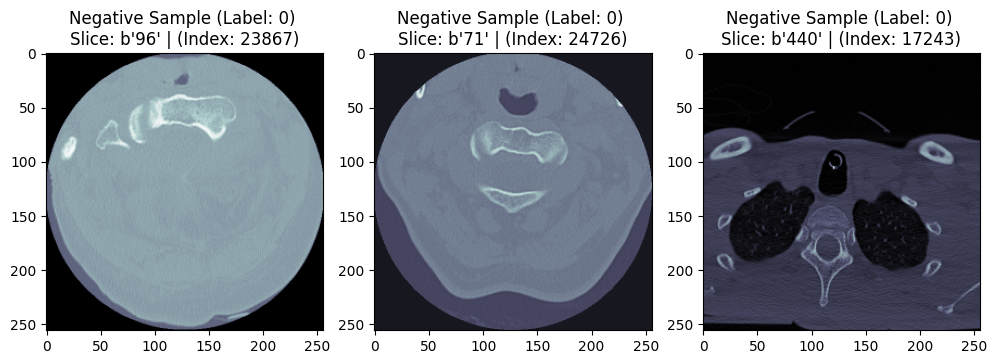

In [9]:
# View 3 sample negative images
visualize_samples(3, 0)

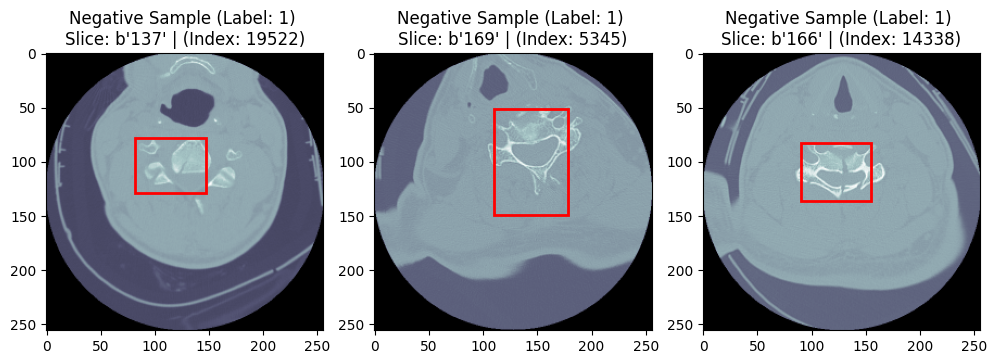

In [13]:
# View 3 sample positive images
visualize_samples(3, 1)

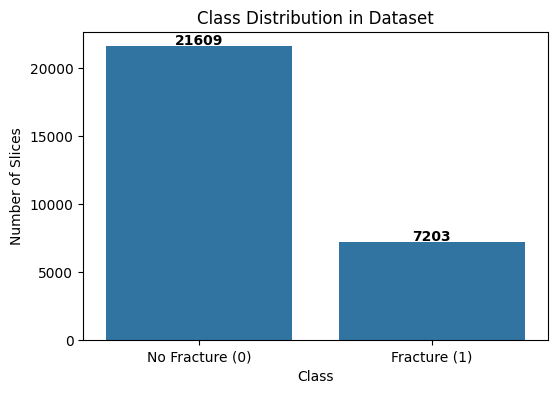

Ratio: 1 Positive (Fracture) for every 3 Negative (No Fracture)


In [14]:
# Check class balance

# Get labels
with h5py.File(data_path, 'r') as f:
    labels = f['labels'][:]

# Calculate counts
unique, counts = np.unique(labels, return_counts=True)
class_names = ['No Fracture (0)', 'Fracture (1)']

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=class_names, y=counts)
plt.title("Class Distribution in Dataset")
plt.ylabel("Number of Slices")
plt.xlabel("Class")

# Add count labels on top
for i, v in enumerate(counts):
    plt.text(i, v + 150, str(v), ha='center', fontweight='bold')

plt.show()
print(f'Ratio: 1 Positive (Fracture) for every {int(counts[0]/counts[1])} Negative (No Fracture)')

In [15]:
# Get labels with splits
with h5py.File(data_path, 'r') as f:
    splits = f['split'][:] # 0=Train, 1=Val, 2=Test
    labels = f['labels'][:] # 0=Negative, 1=Positive

# Create dataFrame
eda_df = pd.DataFrame({
    'split_id': splits,
    'label_id': labels
})

# Map id to split/label names
split_map = {0: 'Train', 1: 'Validation', 2: 'Test'}
label_map = {0: 'No Fracture', 1: 'Fracture'}
eda_df['split'] = eda_df['split_id'].map(split_map)
eda_df['label'] = eda_df['label_id'].map(label_map)

# Counts by split and label
cnt = eda_df.groupby(['split', 'label']).size().reset_index(name='count')

# Reorder for consistent display (Train -> Val -> Test)
cnt['split'] = pd.Categorical(cnt['split'], categories=['Train', 'Validation', 'Test'], ordered=True)
cnt = cnt.sort_values('split')
print('\x1B[4m' + 'Sample Counts by Split and Class' + '\x1B[0m')
display(cnt)

# Check if ratio is consistent across splits
print('\n\x1B[4m' + 'Fracture Rate per Split' + '\x1B[0m')
for split_name in ['Train', 'Validation', 'Test']:
    subset = eda_df[eda_df['split'] == split_name]
    pos_rate = subset['label_id'].mean()
    print(f'{split_name}: {pos_rate:.1%} Positive')

Sample Counts by Split and Class


,split,label,count
2,Train,Fracture,5186
3,Train,No Fracture,15558
4,Validation,Fracture,1045
5,Validation,No Fracture,3135
0,Test,Fracture,972
1,Test,No Fracture,2916



Fracture Rate per Split
Train: 25.0% Positive
Validation: 25.0% Positive
Test: 25.0% Positive


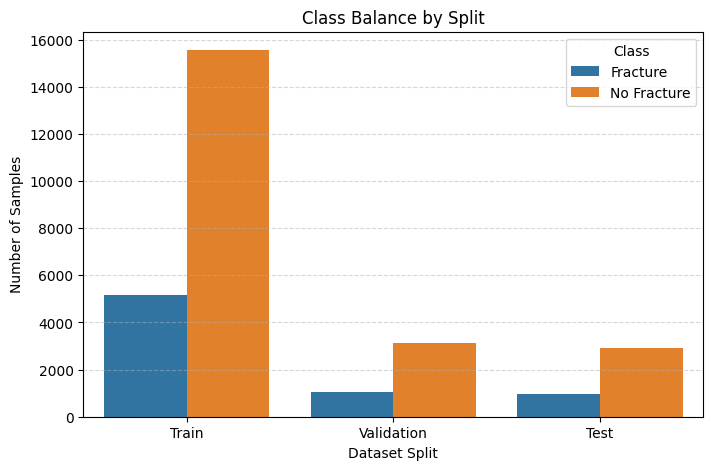

In [16]:
# Plot class balance by split
plt.figure(figsize=(8, 5))
sns.barplot(data=cnt, x='split', y='count', hue='label')
plt.title('Class Balance by Split')
plt.xlabel('Dataset Split')
plt.ylabel('Number of Samples')
plt.legend(title='Class')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

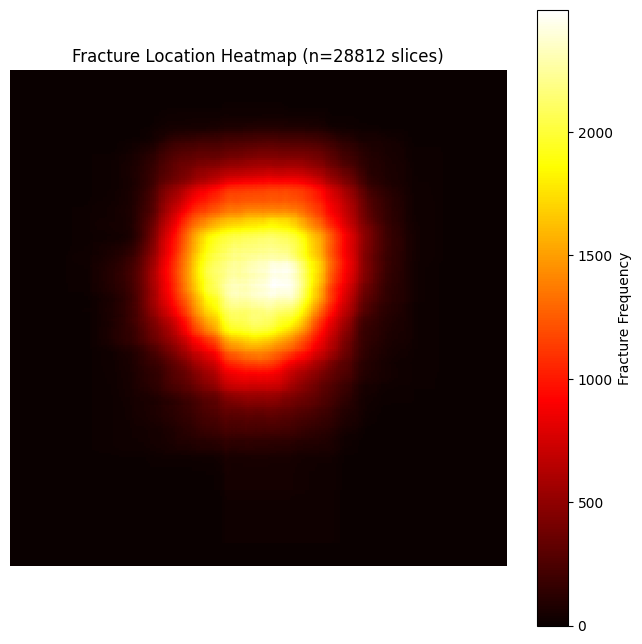

In [17]:
# Plot heatmap of fracture locations
# This shows us where fractures are typically found in the images

# Initialize a blank heatmap
heatmap = np.zeros((256, 256))

# Get all bounding boxes
with h5py.File(data_path, 'r') as f:
    all_bboxes = f['bboxes'][:]

    # Loop through all samples
    for i in range(len(all_bboxes)):
        # Get bounding box for this sample
        bbox = all_bboxes[i]

        # Filter out -1 padding
        valid_box = bbox[bbox[:, 0] != -1]

        for box in valid_box:
            # Box format in H5 is [x, y, w, h] (pixels)
            # We need to make sure it's within 256x256 bounds
            x, y, w, h = box.astype(int)

            # Simple check to ensure indices are valid
            x = max(0, x)
            y = max(0, y)
            w = min(256 - x, w)
            h = min(256 - y, h)

            # Add 1 to the heatmap region corresponding to the box
            heatmap[y:y+h, x:x+w] += 1

# Plot the heatmap
plt.figure(figsize=(8, 8))
plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.colorbar(label='Fracture Frequency')
plt.title(f'Fracture Location Heatmap (n={len(all_bboxes)} slices)')
plt.axis('off')
plt.show()

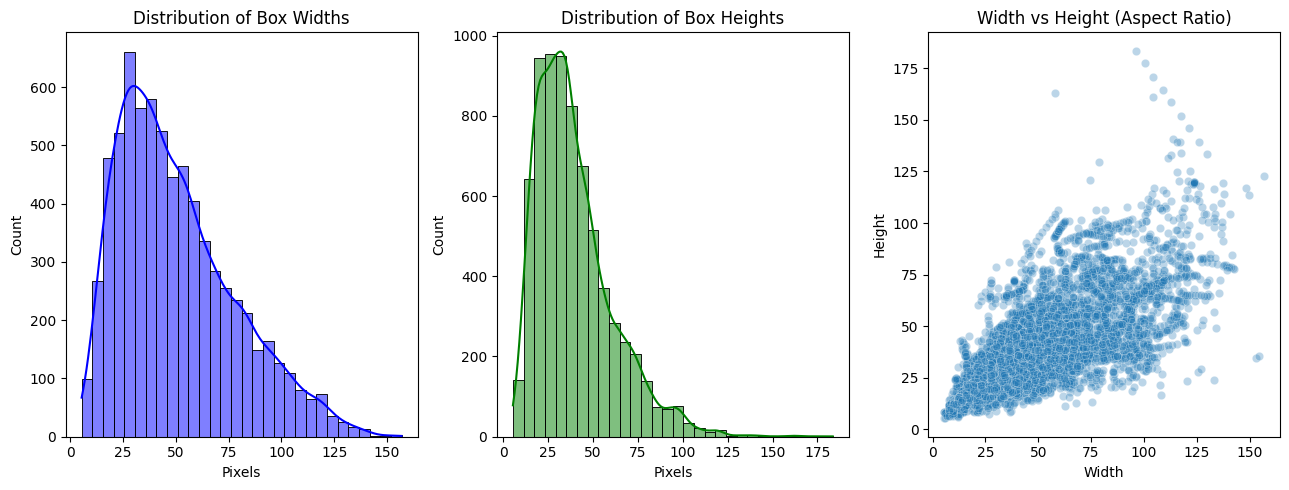

Average Box Size: 50.5 x 39.4 pixels


In [18]:
# Explore bounding box sizes
box_widths = []
box_heights = []
box_areas = []

# Open file and get all bounding boxes
with h5py.File(data_path, 'r') as f:
    all_bboxes = f['bboxes'][:]

    for boxes in all_bboxes:
      # Filter out -1 padding
      valid_boxes = boxes[boxes[:, 0] != -1]

      for box in valid_boxes:
          w, h = box[2], box[3]
          box_widths.append(w)
          box_heights.append(h)
          box_areas.append(w * h)

# Plot histograms
fig, ax = plt.subplots(1, 3, figsize=(13, 5))

sns.histplot(box_widths, bins=30, ax=ax[0], color='blue', kde=True)
ax[0].set_title('Distribution of Box Widths')
ax[0].set_xlabel('Pixels')

sns.histplot(box_heights, bins=30, ax=ax[1], color='green', kde=True)
ax[1].set_title('Distribution of Box Heights')
ax[1].set_xlabel('Pixels')

sns.scatterplot(x=box_widths, y=box_heights, ax=ax[2], alpha=0.3)
ax[2].set_title('Width vs Height (Aspect Ratio)')
ax[2].set_xlabel('Width')
ax[2].set_ylabel('Height')

plt.tight_layout()
plt.show()

print(f'Average Box Size: {np.mean(box_widths):.1f} x {np.mean(box_heights):.1f} pixels')

Loading 1000 random images...


  0%|          | 0/1000 [00:00<?, ?it/s]

Concatenating all pixel values...
Generating histogram plot...


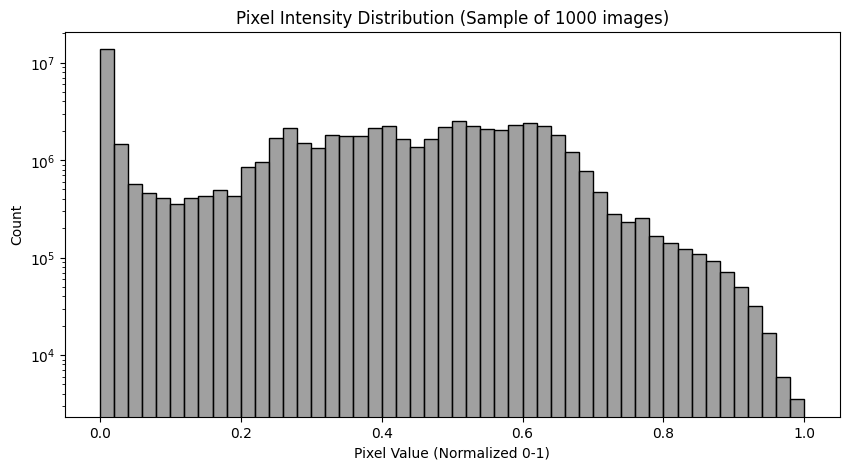

Min Pixel Value: 0.0000
Max Pixel Value: 1.0000
Mean Pixel Value: 0.3466


In [19]:
# Check pixel intensity distribution

# Sample 1000 random images just to check
num_samples_to_check = 1000

with h5py.File(data_path, 'r') as f:
    total_images = f['images'].shape[0]
    indices = np.random.choice(total_images, num_samples_to_check, replace=False)
    indices.sort() # Sort for faster image reading from HDF5 file

    # Load sample images and check pixel values
    pixel_values = []
    print(f'Loading {num_samples_to_check} random images...')
    for idx in tqdm(indices):
        img = f['images'][idx]
        pixel_values.append(img.flatten())

    print('Concatenating all pixel values...')
    all_pixels = np.concatenate(pixel_values)

# Plot
print('Generating histogram plot...')
plt.figure(figsize=(10, 5))
sns.histplot(all_pixels, bins=50, color='gray', kde=False)
plt.title(f'Pixel Intensity Distribution (Sample of {num_samples_to_check} images)')
plt.xlabel('Pixel Value (Normalized 0-1)')
plt.ylabel('Count')
plt.yscale('log') # Log scale helps see the details in dark/bright areas
plt.show()

print(f'Min Pixel Value: {all_pixels.min():.4f}')
print(f'Max Pixel Value: {all_pixels.max():.4f}')
print(f'Mean Pixel Value: {all_pixels.mean():.4f}')

In [20]:
# Check patient id overlapping

# Load split IDs and Patient UIDs
with h5py.File(data_path, 'r') as f:
    splits = f['split'][:] # 0=Train, 1=Val, 2=Test
    uids = f['StudyInstanceUID'][:]

# Get unique patients in each split
train_patients = set(uids[splits == 0])
val_patients = set(uids[splits == 1])
test_patients = set(uids[splits == 2])

# Check for intersections
train_val_overlap = train_patients.intersection(val_patients)
train_test_overlap = train_patients.intersection(test_patients)
val_test_overlap = val_patients.intersection(test_patients)

print(f'Unique Patients in Train: {len(train_patients)}')
print(f'Unique Patients in Val:   {len(val_patients)}')
print(f'Unique Patients in Test:  {len(test_patients)}')
print("-" * 30)
print(f'Train-Val Overlap:  {len(train_val_overlap)} patients')
print(f'Train-Test Overlap: {len(train_test_overlap)} patients')
print(f'Val-Test Overlap:   {len(val_test_overlap)} patients')

if len(train_val_overlap) + len(train_test_overlap) + len(val_test_overlap) == 0:
    print('\n✅ SUCCESS: No patient leakage detected between splits!')
else:
    print('\n❌ WARNING: Patient leakage detected! Your splits are not independent.')

Unique Patients in Train: 1411
Unique Patients in Val:   302
Unique Patients in Test:  303
------------------------------
Train-Val Overlap:  0 patients
Train-Test Overlap: 0 patients
Val-Test Overlap:   0 patients

✅ SUCCESS: No patient leakage detected between splits!


In [21]:
# Verify image dimensions (should be 256x256)
with h5py.File(data_path, 'r') as f:
  # Also check the dataset definition itself
  dset = f['images']
  print(f"Full Dataset Shape: {dset.shape}")
  print(f"Full Dataset Chunks: {dset.chunks}")

Full Dataset Shape: (28812, 256, 256)
Full Dataset Chunks: (32, 256, 256)
